# Redes Neuronales Recurrentes (RNN)

- MLP y CNN solo aceptan un vector de entrada de tamaño fijo y devuelve un vector de salida de tamaño fijo, en cambio, RNN trabaja con secuencias variables tanto a la entrada como a la salida.
- Encontrar una fórmula que explique una secuencia ordenada, recursivamente. 
- Usar la salida de una red, para entrenar otra red.
- RNN tiene memoria a corto plazo, y a largo plazo suele tener problemas. Es ahí donde aparecen las LSTM (redes de memoria a largo plazo), para mejorar este aspecto.

![rnn.jpeg](../../Imagenes/rnn.jpeg)

Aclaraciones: 
- Cada cuadrado NO es una neurona si no una capa que puede contener N neuronas
- Cada flecha representa la interconexión entre dos capas. Los pesos forman una matriz de la N1xN2 donde N1 y N2 son la cantidad de neuronas en cada capa respectivamente.

#### Tipos
- **One to One**: CNN, MLP
- **One to many**: [Image captioning](https://www.youtube.com/watch?v=xKt21ucdBY0)
- **Many to one**: Sentiment Analisys, Detectar voz de hombre vs voz de mujer
- **Many to Many** [(sequence to sequence)](https://youtu.be/dkHdEAJnV_w): [Traducción](https://github.com/jganzabal/aind2-nlp-capstone/blob/master/machine_translation.ipynb)
- **Many to Many Sincronizado**: Etiquetado de tramas de video, Controlar una silla de ruedas, POS (Part of Speech) cada palabra se clasifica en verbo, articulo, etc

#### Usos
- Predecir la proxima palabra en funcion de las anteriores
- Predecir el proximo caracter en función de los anteriores
- **No es buena** para predecir el futuro en secuencias temporales

**Resultado**: Probabilidad en función de una secuencia

(Mas allá de la posibilidad de generar texto):
- OCR
- Speach2Text
- Detección de autores

---
**Parámetros**: 
- N => Cantidad de muestras
- T => Longitud de la secuencia (Cantidad de caracteres de cada muestra)
- D => Cantidad de features

In [1]:
from keras.layers import SimpleRNN, Dense
from keras.models import Sequential
from RNN_utils import encode_io_pairs, chars_to_one_hot, sample, window_transform_text
import numpy as np

import sys
sys.path.insert(0, '../../Utils')
from fnn_helper import PlotLosses

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
text = "MACHINE LEARNING"
chars = sorted(set(text))
window_size = 1
indices_to_chars = dict((i, c) for i, c in enumerate(chars))
chars_to_indices = dict((c, i) for i, c in enumerate(chars))
one_hot_text = chars_to_one_hot(text, chars, chars_to_indices, window_size)*1
print(one_hot_text)

[[[0 0 0 0 0 0 0 0 1 0 0]
  [0 1 0 0 0 0 0 0 0 0 0]
  [0 0 1 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 1 0 0 0 0 0]
  [0 0 0 0 0 0 1 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 1 0]
  [0 0 0 1 0 0 0 0 0 0 0]
  [1 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 1 0 0 0]
  [0 0 0 1 0 0 0 0 0 0 0]
  [0 1 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 1]
  [0 0 0 0 0 0 0 0 0 1 0]
  [0 0 0 0 0 0 1 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 1 0]
  [0 0 0 0 1 0 0 0 0 0 0]]]


### T = 1
#### Stateless

In [5]:
step_size = 1
# encode_io_pairs llama a window_transform_text y despues codifica en one-hot
X, y = encode_io_pairs(text, chars, window_size, step_size)
print('N: ', X.shape[0])
print('T: ', X.shape[1])
print('D: ', X.shape[2])

N:  15
T:  1
D:  11


In [6]:

for xi in X:
    print(xi*1, indices_to_chars[np.argmax(xi)])

[[0 0 0 0 0 0 0 0 1 0 0]] M
[[0 1 0 0 0 0 0 0 0 0 0]] A
[[0 0 1 0 0 0 0 0 0 0 0]] C
[[0 0 0 0 0 1 0 0 0 0 0]] H
[[0 0 0 0 0 0 1 0 0 0 0]] I
[[0 0 0 0 0 0 0 0 0 1 0]] N
[[0 0 0 1 0 0 0 0 0 0 0]] E
[[1 0 0 0 0 0 0 0 0 0 0]]  
[[0 0 0 0 0 0 0 1 0 0 0]] L
[[0 0 0 1 0 0 0 0 0 0 0]] E
[[0 1 0 0 0 0 0 0 0 0 0]] A
[[0 0 0 0 0 0 0 0 0 0 1]] R
[[0 0 0 0 0 0 0 0 0 1 0]] N
[[0 0 0 0 0 0 1 0 0 0 0]] I
[[0 0 0 0 0 0 0 0 0 1 0]] N


In [7]:
for yi in y:
    print(yi*1, indices_to_chars[np.argmax(yi)])

[0 1 0 0 0 0 0 0 0 0 0] A
[0 0 1 0 0 0 0 0 0 0 0] C
[0 0 0 0 0 1 0 0 0 0 0] H
[0 0 0 0 0 0 1 0 0 0 0] I
[0 0 0 0 0 0 0 0 0 1 0] N
[0 0 0 1 0 0 0 0 0 0 0] E
[1 0 0 0 0 0 0 0 0 0 0]  
[0 0 0 0 0 0 0 1 0 0 0] L
[0 0 0 1 0 0 0 0 0 0 0] E
[0 1 0 0 0 0 0 0 0 0 0] A
[0 0 0 0 0 0 0 0 0 0 1] R
[0 0 0 0 0 0 0 0 0 1 0] N
[0 0 0 0 0 0 1 0 0 0 0] I
[0 0 0 0 0 0 0 0 0 1 0] N
[0 0 0 0 1 0 0 0 0 0 0] G


In [8]:
model = Sequential()
model.add(SimpleRNN(10, input_shape=(window_size,len(chars))))
model.add(Dense(len(chars), activation="softmax"))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 10)                220       
_________________________________________________________________
dense_1 (Dense)              (None, 11)                121       
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________


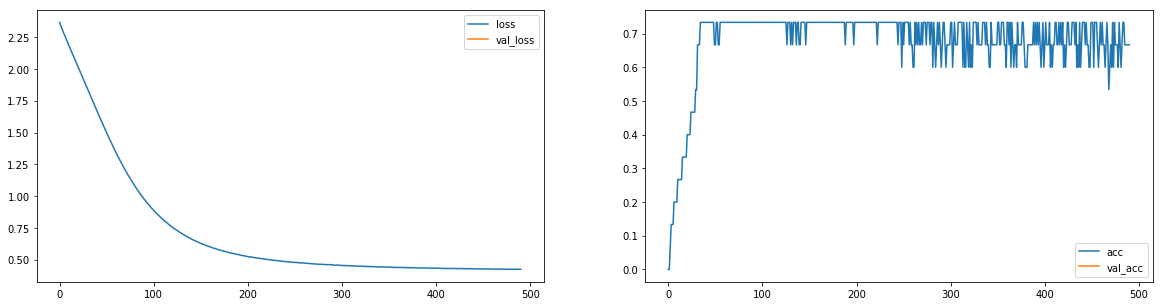

Epoch 492/500
15/15 [==============================] - 0s 1ms/step - loss: 0.4213 - acc: 0.7333
Epoch 493/500
15/15 [==============================] - 0s 2ms/step - loss: 0.4225 - acc: 0.6667
Epoch 494/500
15/15 [==============================] - 0s 2ms/step - loss: 0.4233 - acc: 0.6000
Epoch 495/500
15/15 [==============================] - 0s 2ms/step - loss: 0.4240 - acc: 0.6000
Epoch 496/500
15/15 [==============================] - 0s 2ms/step - loss: 0.4232 - acc: 0.5333
Epoch 497/500
15/15 [==============================] - 0s 2ms/step - loss: 0.4226 - acc: 0.6000
Epoch 498/500
15/15 [==============================] - 0s 2ms/step - loss: 0.4214 - acc: 0.7333
Epoch 499/500
15/15 [==============================] - 0s 2ms/step - loss: 0.4226 - acc: 0.6667
Epoch 500/500
15/15 [==============================] - 0s 2ms/step - loss: 0.4228 - acc: 0.6000


In [9]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
plot_losses = PlotLosses(plot_interval=10, evaluate_interval=None)
model.fit(X,y, epochs=500, batch_size=1, verbose=1, callbacks=[plot_losses])

In [10]:
char_to_predict = text[0] # M
to_predict = chars_to_one_hot(char_to_predict, chars, chars_to_indices, window_size)*1
predicted = model.predict(to_predict)
print(indices_to_chars[np.argmax(predicted)], np.max(predicted))

A 0.97194666


### T = 3

In [11]:
window_size = 3
x_3_t, y_3_t = window_transform_text(text, window_size, step_size)
for i, te in enumerate(x_3_t):
    print(te, '->' ,y_3_t[i])
X_3, y_3 = encode_io_pairs(text, chars, window_size, step_size)

MAC -> H
ACH -> I
CHI -> N
HIN -> E
INE ->  
NE  -> L
E L -> E
 LE -> A
LEA -> R
EAR -> N
ARN -> I
RNI -> N
NIN -> G


In [12]:
model_3 = Sequential()
model_3.add(SimpleRNN(10, input_shape=(window_size,len(chars))))
model_3.add(Dense(len(chars), activation="softmax"))
model_3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 10)                220       
_________________________________________________________________
dense_2 (Dense)              (None, 11)                121       
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________


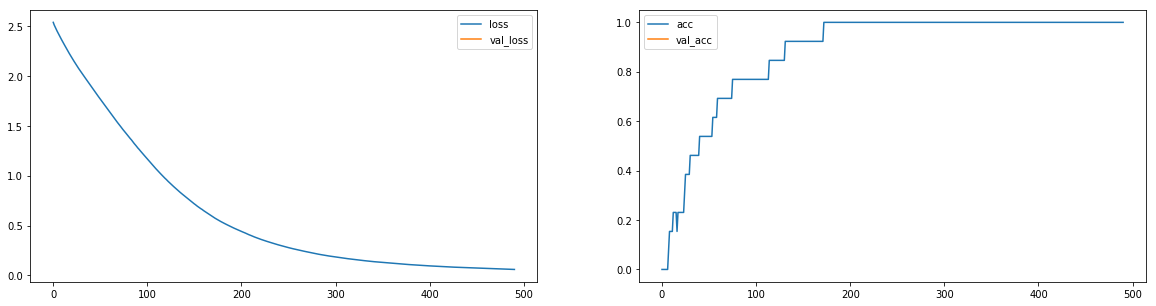

Epoch 492/500
13/13 [==============================] - 0s 593us/step - loss: 0.0600 - acc: 1.0000
Epoch 493/500
13/13 [==============================] - 0s 582us/step - loss: 0.0598 - acc: 1.0000
Epoch 494/500
13/13 [==============================] - 0s 548us/step - loss: 0.0595 - acc: 1.0000
Epoch 495/500
13/13 [==============================] - 0s 827us/step - loss: 0.0592 - acc: 1.0000
Epoch 496/500
13/13 [==============================] - 0s 568us/step - loss: 0.0589 - acc: 1.0000
Epoch 497/500
13/13 [==============================] - 0s 659us/step - loss: 0.0586 - acc: 1.0000
Epoch 498/500
13/13 [==============================] - 0s 712us/step - loss: 0.0584 - acc: 1.0000
Epoch 499/500
13/13 [==============================] - 0s 560us/step - loss: 0.0581 - acc: 1.0000
Epoch 500/500
13/13 [==============================] - 0s 765us/step - loss: 0.0579 - acc: 1.0000


In [13]:
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
plot_losses = PlotLosses(plot_interval=10, evaluate_interval=None)
model_3.fit(X_3,y_3, epochs=500, batch_size=4, verbose=1, callbacks=[plot_losses])

In [14]:
char_to_predict = x_3_t[0] # MAC
to_predict = chars_to_one_hot(char_to_predict, chars, chars_to_indices, window_size)*1
predicted = model_3.predict(to_predict)
print(indices_to_chars[np.argmax(predicted)], np.max(predicted))

H 0.9502071


#### Stateful RNN

In [15]:
window_transform_text(text, 1, 1)
batch_size = 1
model_4 = Sequential()
model_4.add(SimpleRNN(10, batch_input_shape=(batch_size,1,len(chars)), stateful=True))
model_4.add(Dense(len(chars), activation="softmax"))
model_4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (1, 10)                   220       
_________________________________________________________________
dense_3 (Dense)              (1, 11)                   121       
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________


In [18]:
model_4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
for i in range(300):
    model_4.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
    model_4.reset_states()

Epoch 1/1
15/15 [==============================] - 0s 19ms/step - loss: 2.5098 - acc: 0.0000e+00
Epoch 1/1
15/15 [==============================] - 0s 1ms/step - loss: 2.4805 - acc: 0.0667
Epoch 1/1
15/15 [==============================] - 0s 2ms/step - loss: 2.4569 - acc: 0.0667
Epoch 1/1
15/15 [==============================] - 0s 2ms/step - loss: 2.4341 - acc: 0.0667
Epoch 1/1
15/15 [==============================] - 0s 1ms/step - loss: 2.4115 - acc: 0.1333
Epoch 1/1
15/15 [==============================] - 0s 2ms/step - loss: 2.3890 - acc: 0.1333
Epoch 1/1
15/15 [==============================] - 0s 1ms/step - loss: 2.3671 - acc: 0.1333
Epoch 1/1
15/15 [==============================] - 0s 2ms/step - loss: 2.3452 - acc: 0.2000
Epoch 1/1
15/15 [==============================] - 0s 2ms/step - loss: 2.3236 - acc: 0.2667
Epoch 1/1
15/15 [==============================] - 0s 2ms/step - loss: 2.3023 - acc: 0.2667
Epoch 1/1
15/15 [==============================] - 0s 2ms/step - loss: 2.28

#### Secuencias variables en Keras
#### Padding + Masking

In [28]:
from keras.layers import Masking

In [32]:
def code_chars(X, y, chars_to_indices):
    X_coded = []
    y_coded = []
    for i, xi in enumerate(X):
        one_h_y = [0]*(len(chars_to_indices) - 1) # Menos 1 por el '' agregado
        vect = []
        for c in xi:
            one_h = [0]*(len(chars_to_indices) - 1)
            if c == '':
                vect.append(one_h)
            else:
                one_h[chars_to_indices[c]] = 1
                vect.append(one_h)
        X_coded.append(vect)
        one_h_y[chars_to_indices[y[i]]] = 1
        y_coded.append(one_h_y)
    return np.array(X_coded), np.array(y_coded)

In [33]:
def window_transform_text_padding_mode(text):
    len_out = len(text)
    text = text
    X = []
    y = []
    for i in range(len_out):
        #X.append()
        output_start = ['']*(len_out-1)
        output_start[len_out-i-1:len_out] = text[0:i]
        X.append(output_start)
        y.append(text[i])
    return X, y

In [36]:
X_5, y_5 = window_transform_text_padding_mode(text)

In [38]:
chars = sorted(set(text))
chars_to_indices = dict((c, i) for i, c in enumerate(chars))
chars_to_indices[''] = -1
X_coded, y_coded = code_chars(X_5, y_5, chars_to_indices)

In [39]:
model_6 = Sequential()
model_6.add(Masking(mask_value=0., input_shape=(X_coded.shape[1],X_coded.shape[2])))
model_6.add(SimpleRNN(10))
model_6.add(Dense(len(chars), activation="softmax"))
model_6.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, 15, 11)            0         
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 10)                220       
_________________________________________________________________
dense_4 (Dense)              (None, 11)                121       
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________


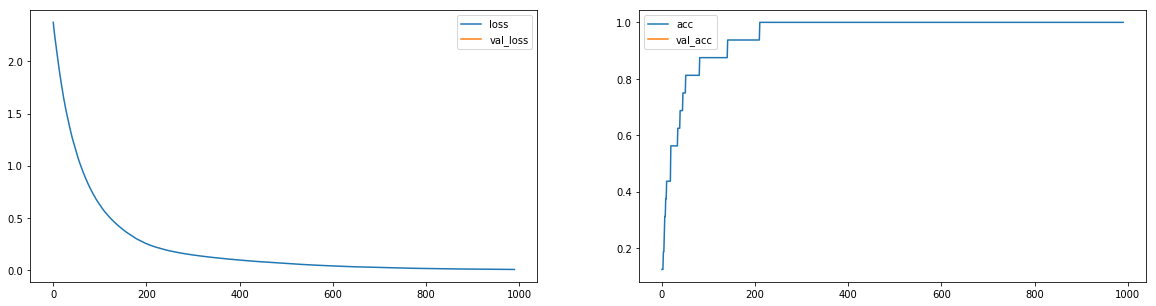

Epoch 992/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.0054 - acc: 1.0000
Epoch 993/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.0054 - acc: 1.0000
Epoch 994/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.0054 - acc: 1.0000
Epoch 995/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.0053 - acc: 1.0000
Epoch 996/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.0053 - acc: 1.0000
Epoch 997/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.0053 - acc: 1.0000
Epoch 998/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.0052 - acc: 1.0000
Epoch 999/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.0052 - acc: 1.0000
Epoch 1000/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.0052 - acc: 1.0000


In [40]:
model_6.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
plot_losses = PlotLosses(plot_interval=10, evaluate_interval=None)
model_6.fit(X_coded,y_coded, epochs=1000, batch_size=1, verbose=1, callbacks=[plot_losses])

In [43]:
to_predict = X_coded
predicted = model_6.predict(to_predict)
for i, row in enumerate(predicted):
    idx = np.argmax(row)
    print(X_5[i], '->', indices_to_chars[idx], int(row[idx]*100)/100)

['', '', '', '', '', '', '', '', '', '', '', '', '', '', ''] -> M 0.92
['', '', '', '', '', '', '', '', '', '', '', '', '', '', 'M'] -> A 0.99
['', '', '', '', '', '', '', '', '', '', '', '', '', 'M', 'A'] -> C 0.99
['', '', '', '', '', '', '', '', '', '', '', '', 'M', 'A', 'C'] -> H 0.99
['', '', '', '', '', '', '', '', '', '', '', 'M', 'A', 'C', 'H'] -> I 0.99
['', '', '', '', '', '', '', '', '', '', 'M', 'A', 'C', 'H', 'I'] -> N 0.99
['', '', '', '', '', '', '', '', '', 'M', 'A', 'C', 'H', 'I', 'N'] -> E 0.99
['', '', '', '', '', '', '', '', 'M', 'A', 'C', 'H', 'I', 'N', 'E'] ->   0.99
['', '', '', '', '', '', '', 'M', 'A', 'C', 'H', 'I', 'N', 'E', ' '] -> L 0.99
['', '', '', '', '', '', 'M', 'A', 'C', 'H', 'I', 'N', 'E', ' ', 'L'] -> E 0.99
['', '', '', '', '', 'M', 'A', 'C', 'H', 'I', 'N', 'E', ' ', 'L', 'E'] -> A 0.99
['', '', '', '', 'M', 'A', 'C', 'H', 'I', 'N', 'E', ' ', 'L', 'E', 'A'] -> R 0.99
['', '', '', 'M', 'A', 'C', 'H', 'I', 'N', 'E', ' ', 'L', 'E', 'A', 'R'] -> N 0.99